In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

## Load and combine raw data from all three batches

In [16]:
batch1 = pickle.load(open(r'../Data/batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

In [17]:
numBat1 = len(batch1.keys())
numBat1

41

In [18]:
batch2 = pickle.load(open(r'../Data/batch2.pkl','rb'))

In [19]:
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

In [20]:
for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

In [21]:
del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

In [22]:
numBat2 = len(batch2.keys())
numBat2

43

In [23]:
batch3 = pickle.load(open(r'../Data/batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c42']
del batch3['b3c43']

In [24]:
numBat3 = len(batch3.keys())
numBat3

40

In [25]:
numBat = numBat1 + numBat2 + numBat3
numBat

124

In [26]:
bat_dict = {**batch1, **batch2, **batch3}

303.3723784232168


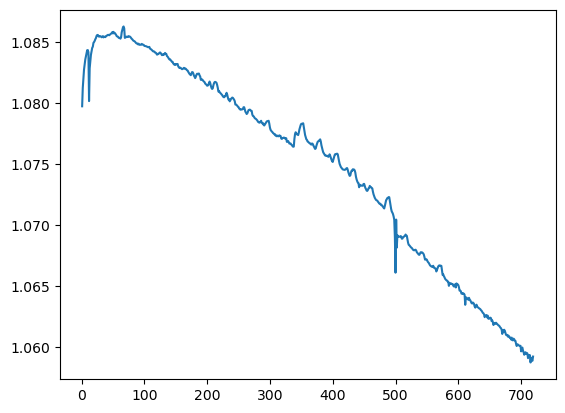

In [883]:
bat = bat_dict['b1c3']


cutoff=720
temps = np.mean(bat['summary']['Tavg'][1:cutoff])+273
Y = 1-bat['summary']['QC'][1:cutoff]/1.1
length = len(bat['summary']['QD'][1:cutoff])
x = np.arange(1,length+1)
plt.plot(x,bat['summary']['QD'][1:cutoff])
print(temps)

A = np.ones((length, 3))
A[:,1] = 1/temps
A[:,2] = np.log(x)

In [884]:
print(bat['cycle_life'])

[[1434.]]


In [885]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return np.exp(a/temps)*x**b + c

param = curve_fit(func, x, Y, maxfev = 4000)[0]

alpha = param[0]
beta = param[1]
gamma = param[2]
#print(gamma)

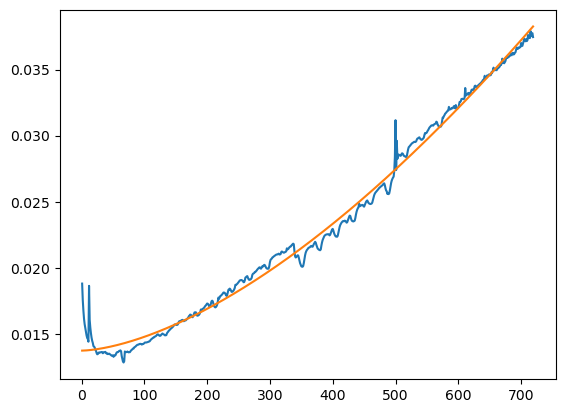

In [886]:

#print(np.exp(alpha/temps)*np.power(x,beta) + gamma * np.log(x))
plt.plot(x, Y)
plt.plot(x, np.exp(alpha/temps)*np.power(x,beta) +gamma)


In [887]:
params = []
for i in bat_dict.keys():
    bat = bat_dict[i]
    temps = np.mean(bat['summary']['Tavg'][1:cutoff])+273
    Y = 1-bat['summary']['QC'][1:cutoff]/1.1
    length = len(bat['summary']['QD'][1:cutoff])
    x = np.arange(1,length+1)
    param = curve_fit(func, x, Y, maxfev = 4000)[0]

    alpha = param[0]
    beta = param[1]
    gamma = param[2]
    params.append([alpha,beta,gamma])
params = np.array(params)

In [888]:
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.metrics import make_scorer
from sklearn.model_selection import *

data = np.loadtxt('./../Data/features4.csv',delimiter=',',skiprows=1) # skip row for column names

In [889]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122])

In [890]:
x_train = data[:,1:6][train_ind]
y_train = params[train_ind]

x_test = data[:,1:6][test_ind]
y_test = params[test_ind]

x_stest = data[:,1:6][secondary_ind]
y_stest = params[secondary_ind]

In [891]:
print(x_train)

[[-5.01395962 -1.95845666 -1.95845666 -0.36716334  0.01246433]
 [-4.44261336 -1.7221493  -1.7221493  -0.35748556  0.03957902]
 [-4.17887796 -1.59896533 -1.59896533 -0.82579434  0.08903088]
 [-3.81348608 -1.41755723 -1.41755723 -0.47701276  0.04942578]
 [-4.14689653 -1.6254072  -1.6254072  -0.22559408  0.0811872 ]
 [-4.0179491  -1.53843313 -1.53843313 -0.31695427  0.09706841]
 [-3.97015945 -1.50768716 -1.50768716 -0.59178048  0.11082608]
 [-3.61990683 -1.33825645 -1.33825645 -0.5631639   0.10565144]
 [-3.35033805 -1.18895973 -1.18895973 -1.04495406  0.05807751]
 [-3.93866252 -1.49699783 -1.49699783 -0.46997571  0.10523357]
 [-3.79522    -1.4161842  -1.4161842  -0.93156119  0.10607864]
 [-3.84471181 -1.42929971 -1.42929971 -0.84577995  0.09288983]
 [-3.74469922 -1.3891761  -1.3891761  -0.54486354  0.0888416 ]
 [-3.6464635  -1.34135637 -1.34135637 -0.80783405  0.1070222 ]
 [-3.84861616 -1.42924531 -1.42924531 -0.82130741  0.07184525]
 [-3.66950134 -1.35045675 -1.35045675 -1.6176157   0.10

[2365 1359  697  785 1206 1001  751  671  453  827  517  567  710  548
  583  316  398  782  482  512  972  552  547  800  445  393  676  354
  508  661  309  450  693  246  428  564  476  371  504  269  330]
[2160. 1434. 1074.  870.  788.  719.  857.  788.  559. 1017.  870.  860.
  709.  731.  742.  704.  617.  966.  702.  616.  300.  438.  444.  511.
  477.  483.  494.  461.  489.  527.  461.  468.  498.  492.  520.  463.
  478.  459.  429.  462.  487.]
217.01680276634534


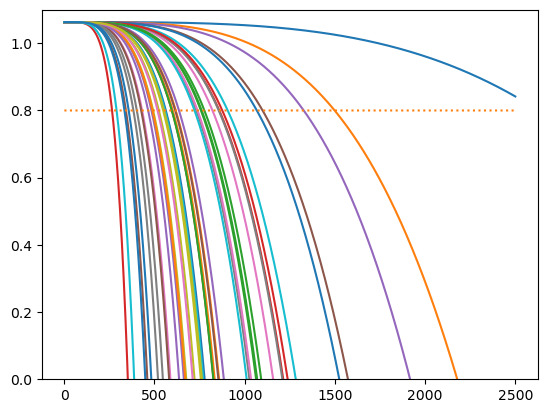

In [892]:
from sklearn.multioutput import MultiOutputRegressor

regr = MultiOutputRegressor(SVR()).fit(x_train, y_train)

predicted = regr.predict(x_train)
x=np.arange(1, 2500)
cycle_lives = []
for p in predicted:
    plt.plot(x, 1.1*(1 - (np.exp(p[0]/temps)*np.power(x,p[1]) + p[2])))
    predicted_array = 1.1*(1 - (np.exp(p[0]/temps)*np.power(x,p[1]) + p[2]))
    cycle_life = np.sum(predicted_array > 0.8*1.1)
    cycle_lives.append(cycle_life)
plt.plot(x, 0.8*np.ones(len(x)), ":")
plt.ylim(0, 1.1)

cycle_lives = np.array(cycle_lives)
truths = data[:, 0][train_ind]
print(cycle_lives)
print(truths)
rmse = np.sqrt(np.mean(np.abs(truths-cycle_lives)**2))
print(rmse)